In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

import yfinance as yf
import tensorflow as tf

In [7]:
stock=yf.Ticker("^NSEBANK")

In [15]:
df=stock.history(period="max")

In [16]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,6897.919911,6977.119187,6842.920550,6897.020020,0,0.0,0.0
2007-09-18 00:00:00+05:30,6921.069480,7078.867940,6883.520112,7059.567871,0,0.0,0.0
2007-09-19 00:00:00+05:30,7110.917439,7419.263957,7110.917439,7401.764160,0,0.0,0.0
2007-09-20 00:00:00+05:30,7404.864086,7462.813119,7343.514701,7390.063965,0,0.0,0.0
2007-09-21 00:00:00+05:30,7378.213894,7506.262696,7367.064122,7464.413086,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-05 00:00:00+05:30,44103.250000,44266.148438,44074.199219,44101.648438,124500,0.0,0.0
2023-06-06 00:00:00+05:30,44156.699219,44236.199219,44009.699219,44164.550781,123600,0.0,0.0
2023-06-07 00:00:00+05:30,44318.699219,44346.300781,44143.500000,44275.300781,119200,0.0,0.0


In [18]:
df1=df.reset_index()['Close']
df1

0        6897.020020
1        7059.567871
2        7401.764160
3        7390.063965
4        7464.413086
            ...     
3579    44101.648438
3580    44164.550781
3581    44275.300781
3582    43995.250000
3583    43989.000000
Name: Close, Length: 3584, dtype: float64

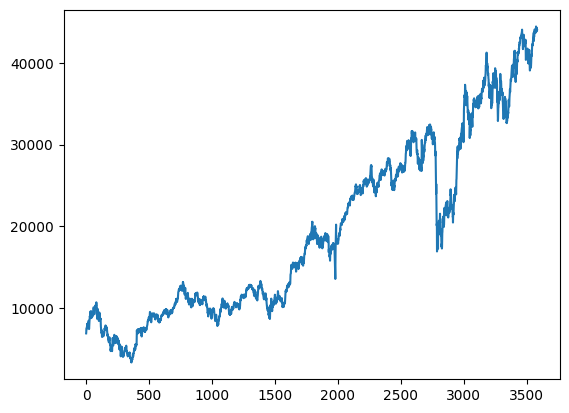

In [22]:
plt.plot(df1)
plt.show()

<h5> LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [25]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [28]:
print(df1)

[[0.08656071]
 [0.09051597]
 [0.09884258]
 ...
 [0.99608117]
 [0.98926674]
 [0.98911466]]


<h5> splitting dataset into train and test split

In [31]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [32]:
training_size,test_size

(2867, 717)

In [33]:
train_data

array([[0.08656071],
       [0.09051597],
       [0.09884258],
       ...,
       [0.43801193],
       [0.44425079],
       [0.45324535]])

In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [37]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
print(X_train.shape) 
print(y_train.shape)

(2766, 100)
(2766,)


In [41]:
print(X_test.shape)
print(ytest.shape)

(616, 100)
(616,)


In [42]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

<h4> Create the Stacked LSTM model

In [54]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(tf.keras.layers.LSTM(50,return_sequences=True))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))

In [55]:
model.compile(optimizer="adam",loss="mean_squared_error")

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
44/44 [==============================] - 21s 292ms/step - loss: 0.0121 - val_loss: 0.0012
Epoch 2/100
44/44 [==============================] - 10s 231ms/step - loss: 5.0269e-04 - val_loss: 0.0019
Epoch 3/100
44/44 [==============================] - 10s 231ms/step - loss: 4.5903e-04 - val_loss: 0.0013
Epoch 4/100
44/44 [==============================] - 11s 240ms/step - loss: 4.2598e-04 - val_loss: 0.0013
Epoch 5/100
44/44 [==============================] - 10s 237ms/step - loss: 3.9994e-04 - val_loss: 0.0016
Epoch 6/100
44/44 [==============================] - 10s 231ms/step - loss: 4.0366e-04 - val_loss: 0.0024
Epoch 7/100
44/44 [==============================] - 10s 236ms/step - loss: 3.8814e-04 - val_loss: 0.0017
Epoch 8/100
44/44 [==============================] - 10s 236ms/step - loss: 3.6701e-04 - val_loss: 8.4071e-04
Epoch 9/100
44/44 [==============================] - 11s 239ms/step - loss: 3.4387e-04 - val_loss: 0.0011
Epoch 10/100
44/44 [==========================

44/44 [==============================] - 10s 233ms/step - loss: 5.9692e-05 - val_loss: 1.5107e-04
Epoch 76/100
44/44 [==============================] - 10s 238ms/step - loss: 6.8741e-05 - val_loss: 3.7170e-04
Epoch 77/100
44/44 [==============================] - 11s 243ms/step - loss: 5.9254e-05 - val_loss: 2.3673e-04
Epoch 78/100
44/44 [==============================] - 10s 232ms/step - loss: 9.5641e-05 - val_loss: 1.4572e-04
Epoch 79/100
44/44 [==============================] - 10s 238ms/step - loss: 6.5904e-05 - val_loss: 1.4630e-04
Epoch 80/100
44/44 [==============================] - 11s 240ms/step - loss: 5.9753e-05 - val_loss: 1.4551e-04
Epoch 81/100
44/44 [==============================] - 10s 232ms/step - loss: 6.4178e-05 - val_loss: 2.1832e-04
Epoch 82/100
44/44 [==============================] - 10s 238ms/step - loss: 6.0124e-05 - val_loss: 2.9592e-04
Epoch 83/100
44/44 [==============================] - 10s 238ms/step - loss: 9.2745e-05 - val_loss: 1.9794e-04
Epoch 84/100
4

In [58]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 63ms/step


In [59]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [62]:
math.sqrt(mean_squared_error(y_train,train_predict))

17896.0792934346

In [63]:
math.sqrt(mean_squared_error(ytest,test_predict))

38377.41386486576

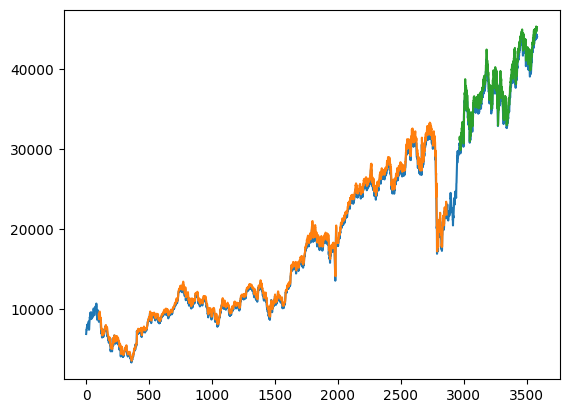

In [66]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [67]:
len(test_data)

717

In [68]:
x_input=test_data[617:].reshape(1,-1)
x_input.shape

(1, 100)

In [75]:
x_input

array([[0.94271798, 0.94975017, 0.94479359, 0.94643606, 0.95186105,
        0.9487185 , 0.95304851, 0.96069996, 0.95856352, 0.93214288,
        0.90045304, 0.90147863, 0.90799014, 0.90453364, 0.90833688,
        0.92854285, 0.92550001, 0.92832994, 0.92946626, 0.92987146,
        0.9299955 , 0.92325045, 0.93215999, 0.9341723 , 0.93174633,
        0.91958959, 0.90912523, 0.90844153, 0.89195108, 0.89208862,
        0.88984629, 0.89952354, 0.89859766, 0.90903883, 0.90153585,
        0.92249984, 0.92490994, 0.93042627, 0.9226312 , 0.90386325,
        0.88145877, 0.87772852, 0.86897116, 0.8709446 , 0.88227154,
        0.87652528, 0.88948861, 0.89202778, 0.88272892, 0.87733805,
        0.8782128 , 0.88153661, 0.88986453, 0.90686104, 0.91183473,
        0.91636302, 0.91738139, 0.91236026, 0.92530173, 0.92996024,
        0.94394194, 0.94710521, 0.94716965, 0.94446386, 0.94727431,
        0.94358788, 0.95618621, 0.95722644, 0.9609104 , 0.96507018,
        0.97074088, 0.9736171 , 0.97265833, 0.98

In [73]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [77]:
temp_input

[0.9427179770953175,
 0.9497501735320221,
 0.9447935890328759,
 0.9464360570587499,
 0.9518610491060157,
 0.94871849830327,
 0.95304851166662,
 0.9606999603711815,
 0.9585635162845166,
 0.9321428782745605,
 0.900453035549191,
 0.9014786275630324,
 0.9079901388234791,
 0.9045336371012045,
 0.9083368820733858,
 0.9285428507004881,
 0.9255000075921372,
 0.9283299381786155,
 0.9294662637138772,
 0.929871462857066,
 0.9299955034111033,
 0.9232504537282277,
 0.9321599873164969,
 0.9341722957988913,
 0.931746328702573,
 0.9195895940050486,
 0.9091252287057121,
 0.9084415323798954,
 0.8919510773599351,
 0.8920886150470554,
 0.8898462850008522,
 0.8995235393208912,
 0.8985976550014446,
 0.9090388280439343,
 0.9015358478032857,
 0.922499842038394,
 0.9249099357458047,
 0.9304262710669632,
 0.9226312014603707,
 0.9038632478080049,
 0.8814587672921027,
 0.8777285208988491,
 0.868971162733579,
 0.8709445956706852,
 0.8822715418343046,
 0.8765252799995703,
 0.8894886109741529,
 0.8920277828979489,
 

In [78]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.0139347]
101
1 day input [0.94975017 0.94479359 0.94643606 0.95186105 0.9487185  0.95304851
 0.96069996 0.95856352 0.93214288 0.90045304 0.90147863 0.90799014
 0.90453364 0.90833688 0.92854285 0.92550001 0.92832994 0.92946626
 0.92987146 0.9299955  0.92325045 0.93215999 0.9341723  0.93174633
 0.91958959 0.90912523 0.90844153 0.89195108 0.89208862 0.88984629
 0.89952354 0.89859766 0.90903883 0.90153585 0.92249984 0.92490994
 0.93042627 0.9226312  0.90386325 0.88145877 0.87772852 0.86897116
 0.8709446  0.88227154 0.87652528 0.88948861 0.89202778 0.88272892
 0.87733805 0.8782128  0.88153661 0.88986453 0.90686104 0.91183473
 0.91636302 0.91738139 0.91236026 0.92530173 0.92996024 0.94394194
 0.94710521 0.94716965 0.94446386 0.94727431 0.94358788 0.95618621
 0.95722644 0.9609104  0.96507018 0.97074088 0.9736171  0.97265833
 0.9817284  0.95680547 0.97195999 0.96987098 0.97310487 0.97661489
 0.98435882 0.99113676 0.98703905 0.98205081 0.98335509 0.9886377
 0.98658651 0.98827394 0.98154353 0

8 day output [[1.209477]]
9 day input [0.93214288 0.90045304 0.90147863 0.90799014 0.90453364 0.90833688
 0.92854285 0.92550001 0.92832994 0.92946626 0.92987146 0.9299955
 0.92325045 0.93215999 0.9341723  0.93174633 0.91958959 0.90912523
 0.90844153 0.89195108 0.89208862 0.88984629 0.89952354 0.89859766
 0.90903883 0.90153585 0.92249984 0.92490994 0.93042627 0.9226312
 0.90386325 0.88145877 0.87772852 0.86897116 0.8709446  0.88227154
 0.87652528 0.88948861 0.89202778 0.88272892 0.87733805 0.8782128
 0.88153661 0.88986453 0.90686104 0.91183473 0.91636302 0.91738139
 0.91236026 0.92530173 0.92996024 0.94394194 0.94710521 0.94716965
 0.94446386 0.94727431 0.94358788 0.95618621 0.95722644 0.9609104
 0.96507018 0.97074088 0.9736171  0.97265833 0.9817284  0.95680547
 0.97195999 0.96987098 0.97310487 0.97661489 0.98435882 0.99113676
 0.98703905 0.98205081 0.98335509 0.9886377  0.98658651 0.98827394
 0.98154353 0.98162983 0.98982031 0.9969717  1.         0.99250054
 0.98427727 0.98787007 0.991

16 day output [[1.3963504]]
17 day input [0.92832994 0.92946626 0.92987146 0.9299955  0.92325045 0.93215999
 0.9341723  0.93174633 0.91958959 0.90912523 0.90844153 0.89195108
 0.89208862 0.88984629 0.89952354 0.89859766 0.90903883 0.90153585
 0.92249984 0.92490994 0.93042627 0.9226312  0.90386325 0.88145877
 0.87772852 0.86897116 0.8709446  0.88227154 0.87652528 0.88948861
 0.89202778 0.88272892 0.87733805 0.8782128  0.88153661 0.88986453
 0.90686104 0.91183473 0.91636302 0.91738139 0.91236026 0.92530173
 0.92996024 0.94394194 0.94710521 0.94716965 0.94446386 0.94727431
 0.94358788 0.95618621 0.95722644 0.9609104  0.96507018 0.97074088
 0.9736171  0.97265833 0.9817284  0.95680547 0.97195999 0.96987098
 0.97310487 0.97661489 0.98435882 0.99113676 0.98703905 0.98205081
 0.98335509 0.9886377  0.98658651 0.98827394 0.98154353 0.98162983
 0.98982031 0.9969717  1.         0.99250054 0.98427727 0.98787007
 0.99185572 0.99338631 0.99608117 0.98926674 0.98911466 1.01393473
 1.04555213 1.0712069

24 day output [[1.5330122]]
25 day input [0.91958959 0.90912523 0.90844153 0.89195108 0.89208862 0.88984629
 0.89952354 0.89859766 0.90903883 0.90153585 0.92249984 0.92490994
 0.93042627 0.9226312  0.90386325 0.88145877 0.87772852 0.86897116
 0.8709446  0.88227154 0.87652528 0.88948861 0.89202778 0.88272892
 0.87733805 0.8782128  0.88153661 0.88986453 0.90686104 0.91183473
 0.91636302 0.91738139 0.91236026 0.92530173 0.92996024 0.94394194
 0.94710521 0.94716965 0.94446386 0.94727431 0.94358788 0.95618621
 0.95722644 0.9609104  0.96507018 0.97074088 0.9736171  0.97265833
 0.9817284  0.95680547 0.97195999 0.96987098 0.97310487 0.97661489
 0.98435882 0.99113676 0.98703905 0.98205081 0.98335509 0.9886377
 0.98658651 0.98827394 0.98154353 0.98162983 0.98982031 0.9969717
 1.         0.99250054 0.98427727 0.98787007 0.99185572 0.99338631
 0.99608117 0.98926674 0.98911466 1.01393473 1.04555213 1.07120693
 1.09217989 1.11241257 1.13424838 1.15814495 1.18350673 1.20947695
 1.2353704  1.26077652 

In [79]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [80]:
len(df1)

3584

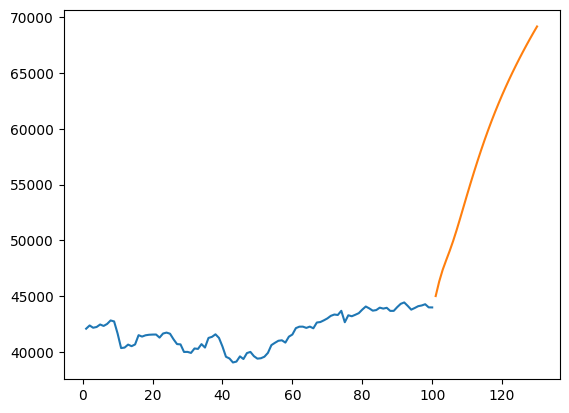

In [81]:
plt.plot(day_new,scaler.inverse_transform(df1[3484:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

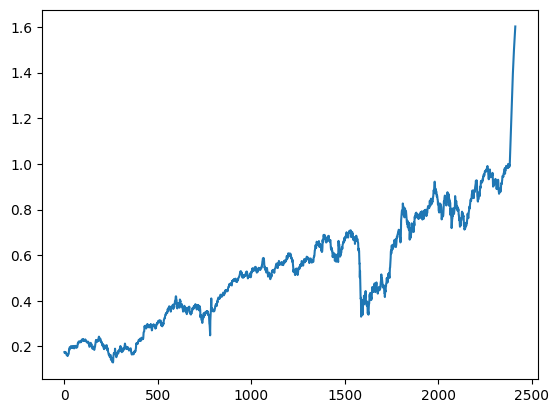

In [82]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

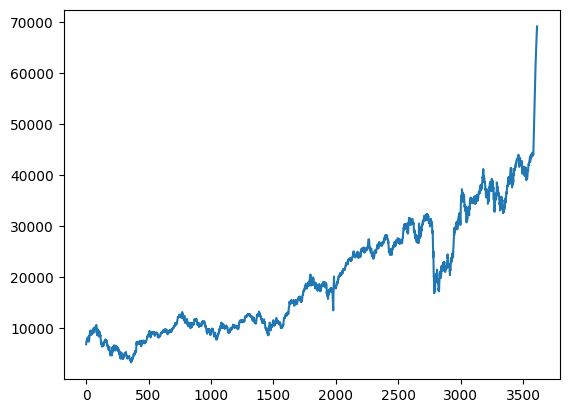

In [83]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)